1.数据加载和合并

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import jieba

# 加载数据
def load_data(file_path):
    return pd.read_csv(file_path, header=None, names=['text'],on_bad_lines='skip')

negative_words_ts = load_data('/content/drive/My Drive/Work/1.高中生情感分类/negative_words.csv')
neutral_words_ts = load_data('/content/drive/My Drive/Work/1.高中生情感分类/neutral_words.csv')
positive_words_ts = load_data('/content/drive/My Drive/Work/1.高中生情感分类/positive_words.csv')

# 设置随机种子
np.random.seed(0)

def add_random_timestamps(df, start_date="2020-01-01", end_date="2024-12-31"):
    dates = pd.date_range(start=start_date, end=end_date).strftime("%Y-%m-%d")
    # 直接从格式化后的字符串日期中随机选择
    df['timestamp'] = np.random.choice(dates, size=len(df))


# 为每个数据集添加随机时间戳
add_random_timestamps(negative_words_ts)
add_random_timestamps(neutral_words_ts)
add_random_timestamps(positive_words_ts)


# 分配标签
neutral_words_ts['label'] = 0
positive_words_ts['label'] = 1
negative_words_ts['label'] = 2

# 合并数据集
data_ts = pd.concat([positive_words_ts, neutral_words_ts, negative_words_ts])

In [3]:
data_ts

,text,timestamp,label
0,除了授课和答疑，我非常希望在课余时间有机会和老师交流。,2023-06-16,1
1,我认为面对学习生活中的压力，要化压力为动力。,2024-08-28,1
2,我会通过与家人朋友聊天，宣泄自己的压力。,2021-01-17,1
3,我会通过读书、听音乐宣泄自己的压力。,2020-08-04,1
4,我比较反感身边同学吸烟，吸烟会危害自己以及身边同学的身心健康。,2023-07-20,1
...,...,...,...
569,“我真的好想回到过去，重新选择一条不同的路。”,2024-01-01,2
570,“我觉得自己好像被困在了这个循环里，每天都过得一模一样。”,2020-07-16,2
571,“每次想到自己的未来，我就会觉得特别迷茫。”,2022-07-18,2
572,“我觉得没人能够理解我，我真的好想有人能理解我，支持我去追求自己的梦想。”,2024-07-29,2


In [4]:
# 使用Pandas将时间戳转换为日期时间对象
data_ts['timestamp'] = pd.to_datetime(data_ts['timestamp'])

# 从时间戳中提取出可能有用的特征
data_ts['year'] = data_ts['timestamp'].dt.year
data_ts['month'] = data_ts['timestamp'].dt.month
data_ts['day'] = data_ts['timestamp'].dt.day
data_ts['dayofweek'] = data_ts['timestamp'].dt.dayofweek

In [5]:
#随机化数据
data_ts = data_ts.sample(frac=1).reset_index(drop=True)

import jieba
import requests

stop_words_url = 'https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt'

# 使用requests库下载停用词库
response = requests.get(stop_words_url)
stop_words = set(response.text.splitlines())

def preprocess_chinese_text(text):
    # 使用jieba进行中文分词
    words = jieba.cut(text)
    # 移除停用词
    filtered_words = [word for word in words if word not in stop_words and not word.isspace()]
    # 合并词汇为一个字符串
    return ' '.join(filtered_words)

# 应用预处理函数到文本列
data_ts['original_text'] = data_ts['text'].copy()
data_ts['text'] = data_ts['text'].apply(preprocess_chinese_text)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.746 seconds.
DEBUG:jieba:Loading model cost 1.746 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [6]:
from gensim.models import KeyedVectors

# 划分数据集
X = data_ts['text']
y = data_ts['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# 文本序列化和填充
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
max_seq_length = 100
X_pad = pad_sequences(X_seq, maxlen=max_seq_length)

# 加载腾讯的预训练模型
model_path = '/content/drive/My Drive/Work/1.高中生情感分类/tencent-ailab-embedding-zh-d100-v0.2.0-s.txt'
word_vectors_zh = KeyedVectors.load_word2vec_format(model_path, binary=False)

In [7]:
# 初始化词嵌入矩阵
embedding_dim = 100  # 根据实际词向量的维度进行设置
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = word_vectors_zh[word] if word in word_vectors_zh else None
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Conv1D, SimpleRNN, GlobalMaxPooling1D, Embedding, Dropout, Dense

In [9]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X_pad, y_categorical, test_size=0.2, random_state=42)

LSTM

In [12]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.models import Model

# 时间特征的输入
time_input = Input(shape=(4,), name='time_input')  # 这里的4是时间特征的数量

# 构建模型
def build_lstm_model_with_time(input_dim, output_dim, input_length, embedding_matrix, time_input_shape):
    # 文本输入部分
    text_input = Input(shape=(input_length,), dtype='int32', name='text')
    embedded_text = Embedding(input_dim=input_dim, output_dim=output_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(text_input)
    lstm_out = LSTM(128, return_sequences=True)(embedded_text)
    lstm_out = LSTM(64)(lstm_out)

    # 时间输入部分
    time_input = Input(shape=(time_input_shape,), name='time_input')
    time_dense = Dense(32, activation='relu')(time_input)

    # 合并文本和时间特征
    concatenated = concatenate([lstm_out, time_dense], axis=-1)

    # 添加一个或多个全连接层
    output = Dense(32, activation='relu')(concatenated)
    output = Dense(len(y_categorical[0]), activation='softmax')(output)

    # 构建最终的模型
    model = Model([text_input, time_input], output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# 模型实例化
lstm_model_with_time = build_lstm_model_with_time(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_seq_length, embedding_matrix=embedding_matrix, time_input_shape=4)


# 划分数据集为训练集和测试集（同时包括时间特征）
X_time_features = data_ts[['year', 'month', 'day', 'dayofweek']]
X_train_time, X_test_time, y_train, y_test = train_test_split(X_time_features, y_categorical, test_size=0.2, random_state=42)


# 模型训练
history_lstm_with_time = lstm_model_with_time.fit([X_train_text, X_train_time], y_train, epochs=10, validation_data=([X_test_text, X_test_time], y_test), batch_size=64)
print(lstm_model_with_time.summary())

Epoch 1/10
21/21 [==============================] - 8s 60ms/step - loss: 36.9210 - accuracy: 0.3147 - val_loss: 18.5098 - val_accuracy: 0.3155
Epoch 2/10
21/21 [==============================] - 0s 14ms/step - loss: 6.6429 - accuracy: 0.3259 - val_loss: 3.3186 - val_accuracy: 0.3185
Epoch 3/10
21/21 [==============================] - 0s 12ms/step - loss: 2.9892 - accuracy: 0.3587 - val_loss: 3.1271 - val_accuracy: 0.4167
Epoch 4/10
21/21 [==============================] - 0s 13ms/step - loss: 1.6533 - accuracy: 0.4966 - val_loss: 1.1802 - val_accuracy: 0.6429
Epoch 5/10
21/21 [==============================] - 0s 13ms/step - loss: 0.9795 - accuracy: 0.6450 - val_loss: 0.7148 - val_accuracy: 0.7173
Epoch 6/10
21/21 [==============================] - 0s 13ms/step - loss: 0.6422 - accuracy: 0.7591 - val_loss: 0.6088 - val_accuracy: 0.7560
Epoch 7/10
21/21 [==============================] - 0s 13ms/step - loss: 0.5499 - accuracy: 0.8091 - val_loss: 0.4740 - val_accuracy: 0.8065
Epoch 8/10


CNN

In [13]:
"""CNN 模型加入时间特征"""

def build_cnn_model_with_time(input_dim, output_dim, input_length, embedding_matrix, time_input_shape):
    # 文本输入部分
    text_input = Input(shape=(input_length,), dtype='int32', name='text')
    embedded_text = Embedding(input_dim=input_dim, output_dim=output_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(text_input)
    conv1d_out = Conv1D(filters=128, kernel_size=5, activation='relu')(embedded_text)
    pooled_text = GlobalMaxPooling1D()(conv1d_out)

    # 时间输入部分
    time_input = Input(shape=(time_input_shape,), name='time_input')
    time_dense = Dense(32, activation='relu')(time_input)

    # 合并文本和时间特征
    concatenated = concatenate([pooled_text, time_dense], axis=-1)

    # 添加一个或多个全连接层
    output = Dense(32, activation='relu')(concatenated)
    output = Dense(len(y_categorical[0]), activation='softmax')(output)

    # 构建最终的模型
    model = Model([text_input, time_input], output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

cnn_model_with_time = build_cnn_model_with_time(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_seq_length, embedding_matrix=embedding_matrix, time_input_shape=4)

# 训练CNN模型
history_cnn_with_time = cnn_model_with_time.fit([X_train_text, X_train_time], y_train, epochs=10, validation_data=([X_test_text, X_test_time], y_test), batch_size=64)

print(cnn_model_with_time.summary())

Epoch 1/10
21/21 [==============================] - 3s 19ms/step - loss: 18.7412 - accuracy: 0.3512 - val_loss: 10.6111 - val_accuracy: 0.3155
Epoch 2/10
21/21 [==============================] - 0s 6ms/step - loss: 4.6087 - accuracy: 0.3729 - val_loss: 3.0528 - val_accuracy: 0.3155
Epoch 3/10
21/21 [==============================] - 0s 6ms/step - loss: 1.8648 - accuracy: 0.4236 - val_loss: 1.0059 - val_accuracy: 0.5179
Epoch 4/10
21/21 [==============================] - 0s 6ms/step - loss: 0.9850 - accuracy: 0.5749 - val_loss: 0.8516 - val_accuracy: 0.6190
Epoch 5/10
21/21 [==============================] - 0s 6ms/step - loss: 0.7146 - accuracy: 0.6689 - val_loss: 0.5877 - val_accuracy: 0.7500
Epoch 6/10
21/21 [==============================] - 0s 6ms/step - loss: 0.5931 - accuracy: 0.7412 - val_loss: 1.0210 - val_accuracy: 0.4881
Epoch 7/10
21/21 [==============================] - 0s 6ms/step - loss: 0.5856 - accuracy: 0.7435 - val_loss: 0.5466 - val_accuracy: 0.7411
Epoch 8/10
21/21 

RNN

In [14]:
"""RNN 模型加入时间特征"""

def build_rnn_model_with_time(input_dim, output_dim, input_length, embedding_matrix, time_input_shape):
    # 文本输入部分
    text_input = Input(shape=(input_length,), dtype='int32', name='text')
    embedded_text = Embedding(input_dim=input_dim, output_dim=output_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(text_input)
    rnn_out = SimpleRNN(128, return_sequences=True)(embedded_text)
    rnn_out = SimpleRNN(64)(rnn_out)

    # 时间输入部分
    time_input = Input(shape=(time_input_shape,), name='time_input')
    time_dense = Dense(32, activation='relu')(time_input)

    # 合并文本和时间特征
    concatenated = concatenate([rnn_out, time_dense], axis=-1)

    # 添加一个或多个全连接层
    output = Dense(32, activation='relu')(concatenated)
    output = Dense(len(y_categorical[0]), activation='softmax')(output)

    # 构建最终的模型
    model = Model([text_input, time_input], output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

rnn_model_with_time = build_rnn_model_with_time(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_seq_length, embedding_matrix=embedding_matrix, time_input_shape=4)

# 训练RNN模型
history_rnn_with_time = rnn_model_with_time.fit([X_train_text, X_train_time], y_train, epochs=10, validation_data=([X_test_text, X_test_time], y_test), batch_size=64)

print(rnn_model_with_time.summary())

Epoch 1/10
21/21 [==============================] - 6s 162ms/step - loss: 23.0212 - accuracy: 0.3393 - val_loss: 6.6686 - val_accuracy: 0.3155
Epoch 2/10
21/21 [==============================] - 3s 150ms/step - loss: 3.9922 - accuracy: 0.3758 - val_loss: 1.3646 - val_accuracy: 0.4792
Epoch 3/10
21/21 [==============================] - 4s 205ms/step - loss: 1.1436 - accuracy: 0.4914 - val_loss: 0.9327 - val_accuracy: 0.5744
Epoch 4/10
21/21 [==============================] - 3s 140ms/step - loss: 0.8195 - accuracy: 0.6376 - val_loss: 0.6970 - val_accuracy: 0.7143
Epoch 5/10
21/21 [==============================] - 3s 147ms/step - loss: 0.6952 - accuracy: 0.7040 - val_loss: 0.6031 - val_accuracy: 0.7679
Epoch 6/10
21/21 [==============================] - 4s 194ms/step - loss: 0.6239 - accuracy: 0.7599 - val_loss: 0.4937 - val_accuracy: 0.8036
Epoch 7/10
21/21 [==============================] - 4s 169ms/step - loss: 0.4837 - accuracy: 0.8113 - val_loss: 0.4569 - val_accuracy: 0.8036
Epoch

性能对比

In [15]:
import matplotlib.pyplot as plt

def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

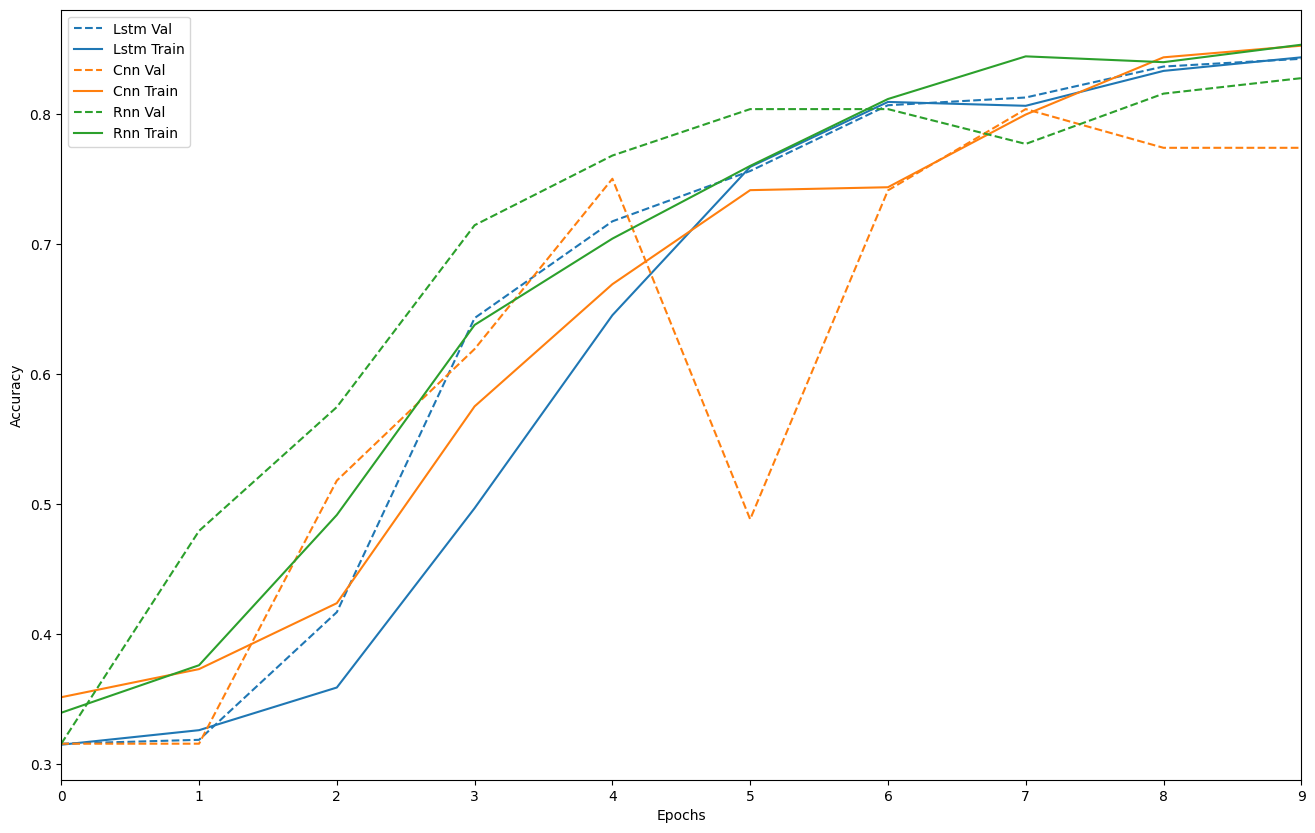

In [16]:
# 绘制模型性能
plot_history([('lstm', history_lstm_with_time), ('cnn', history_cnn_with_time), ('rnn', history_rnn_with_time)], key='accuracy')

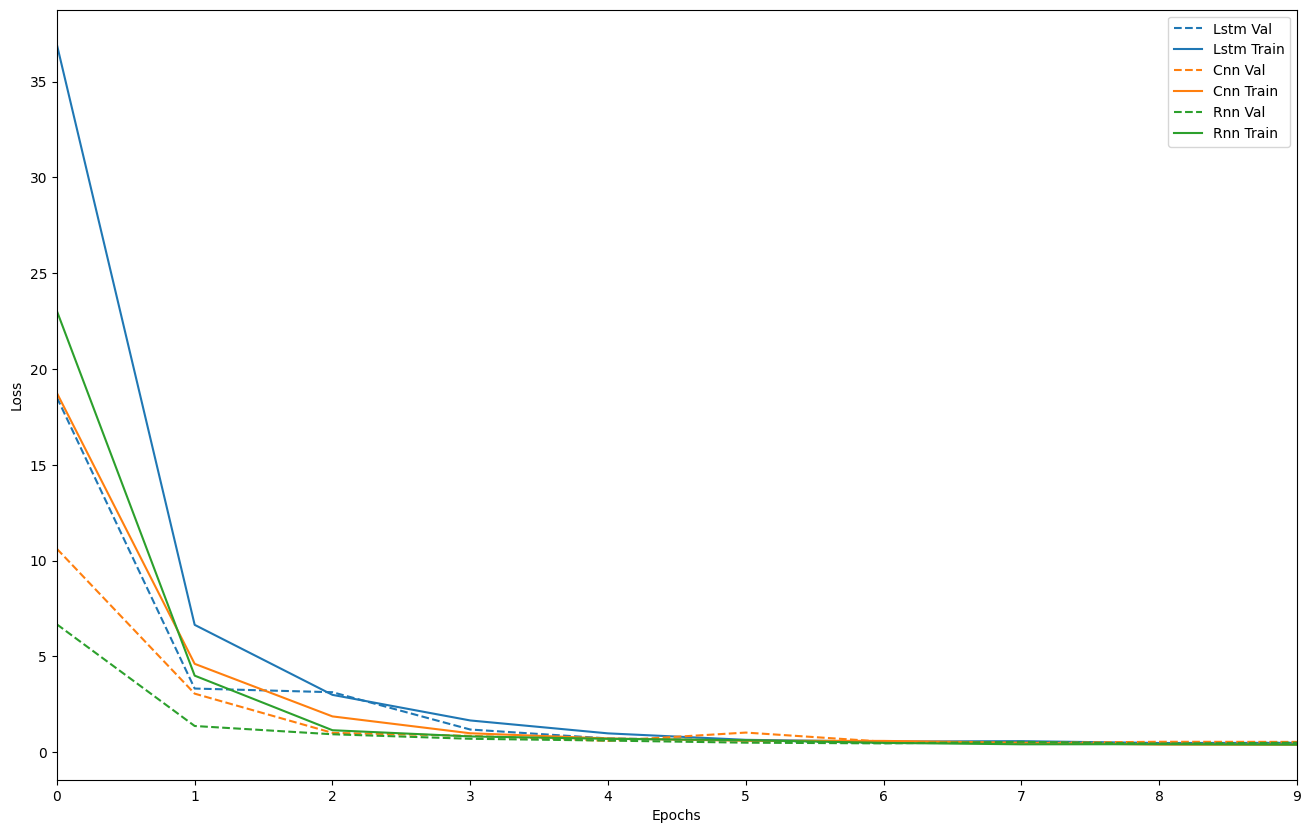

In [17]:
plot_history([('lstm', history_lstm_with_time), ('cnn', history_cnn_with_time), ('rnn', history_rnn_with_time)], key='loss')

In [21]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
import numpy as np

# 计算每个模型的性能指标
def evaluate_model(model, X_test_text, X_test_time, y_test):
    # 确保模型预测时使用了两个输入：文本和时间特征
    y_pred = model.predict([X_test_text, X_test_time])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    return accuracy, f1, recall


metrics_lstm_with_time = evaluate_model(lstm_model_with_time, X_test_text, X_test_time, y_test)
metrics_cnn_with_time = evaluate_model(cnn_model_with_time, X_test_text, X_test_time, y_test)
metrics_rnn_with_time = evaluate_model(rnn_model_with_time, X_test_text, X_test_time, y_test)


11/11 [==============================] - 1s 79ms/step


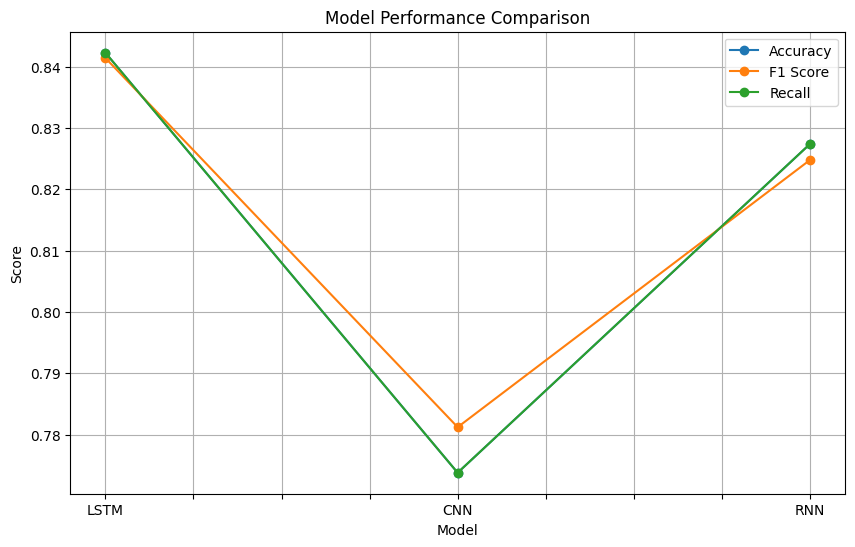

In [22]:
# 绘制性能对比图
metrics = np.array([metrics_lstm_with_time, metrics_cnn_with_time, metrics_rnn_with_time])
metrics_df = pd.DataFrame(metrics, index=['LSTM', 'CNN', 'RNN'], columns=['Accuracy', 'F1 Score', 'Recall'])

metrics_df.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.grid(True)
plt.show()


In [23]:
print(metrics_df)

      Accuracy  F1 Score    Recall
LSTM  0.842262  0.841413  0.842262
CNN   0.773810  0.781232  0.773810
RNN   0.827381  0.824773  0.827381


# 训练过程

In [24]:
!pip install ipywidgets
from ipywidgets import widgets, Layout
from IPython.display import display
from sklearn.metrics import accuracy_score, recall_score, f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.6 MB/s eta 0:00:00


In [25]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# 定义绘制模型性能图表的函数
def plot_model_performance(history, title):
    clear_output(wait=True)  # 清除之前的输出
    plt.figure(figsize=(12, 4))

    # 绘制训练 & 验证的准确率值
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy - {title}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # 绘制训练 & 验证的损失值
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss - {title}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.tight_layout()
    plt.show()

# 为每个模型创建一个查询按钮，并绑定事件
def create_query_button(model_name, history):
    button = widgets.Button(description=f"Query {model_name} Model",
                            layout=widgets.Layout(width='200px'))
    def on_button_clicked(b):
        with output:
            plot_model_performance(history, model_name)

    button.on_click(on_button_clicked)
    display(button)

# 输出区域
output = widgets.Output()

# 显示所有按钮和输出区域
create_query_button('LSTM', history_lstm_with_time)
create_query_button('CNN', history_cnn_with_time)
create_query_button('RNN', history_rnn_with_time)
display(output)


Button(description='Query LSTM Model', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='Query CNN Model', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='Query RNN Model', layout=Layout(width='200px'), style=ButtonStyle())

Output()

# **图形化**

In [51]:
output_area2 = widgets.Output()

In [52]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [53]:
# 模型预测函数，包含文本和时间特征
def predict_with_model(model, X_text, X_time):
    predictions = model.predict([X_text, X_time])
    return np.argmax(predictions, axis=1)

In [62]:
# 查询并显示结果的函数
def display_statements(model, emotion, num_statements, data_ts, X_test_text, X_test_time):
    predicted_classes = predict_with_model(model, X_test_text, X_test_time)
    # 将用户选择的情感转换为对应的整数标签
    emotion_to_label = {'积极': 1, '中立': 0, '消极': 2}
    label = emotion_to_label[emotion]

    # 获取对应情感预测的索引
    selected_indices = np.where(predicted_classes == label)[0]

    # 如果用户指定的数量超过了找到的文本数量，调整为实际数量
    num_statements = min(num_statements, len(selected_indices))

    # 随机选择指定数量的索引
    if num_statements > 0:
        selected_samples = np.random.choice(selected_indices, num_statements, replace=False)
    else:
        selected_samples = []

    # 显示这些文本
    for idx in selected_samples:
        print(data_ts.iloc[idx]['original_text'])  # 确保你有一个保存原始文本的列，这里使用了'text'


# 显示模型性能指标的函数
def display_performance(model, emotion, data_ts, X_test_text, X_test_time, y_test):
    # 根据情感筛选对应的文本和标签
    emotion_to_label = {'积极': 1, '中立': 0, '消极': 2}
    label = emotion_to_label[emotion]
    indices = np.where(np.argmax(y_test, axis=1) == label)[0]

    # 如果X_test_text和X_test_time是DataFrame，需要使用iloc来获取行
    selected_X_test_text = X_test_text.iloc[indices] if isinstance(X_test_text, pd.DataFrame) else X_test_text[indices]
    selected_X_test_time = X_test_time.iloc[indices] if isinstance(X_test_time, pd.DataFrame) else X_test_time[indices]
    selected_y_test = y_test[indices]

    # 确保predictions是根据model预测出的
    predictions = predict_with_model(model, selected_X_test_text, selected_X_test_time)
    accuracy = accuracy_score(np.argmax(selected_y_test, axis=1), predictions)
    recall = recall_score(np.argmax(selected_y_test, axis=1), predictions, average='macro')
    f1 = f1_score(np.argmax(selected_y_test, axis=1), predictions, average='macro')

    # 显示性能指标
    print(f"准确率: {accuracy:.2f}")
    print(f"召回率: {recall:.2f}")
    print(f"F1得分: {f1:.2f}")


In [60]:
query_button = widgets.Button(
    description='查询',
    button_style='success',
)


# 按钮点击事件处理函数
def on_query_button_clicked(b):
    with output_area2:
      output_area2.clear_output(wait=True)  # 清除输出区域的内容
      selected_model = model_dropdown.value
      emotion = emotion_dropdown.value
      num_statements = num_statements_input.value

      # 根据选择的模型调用相应的函数
      if selected_model == 'LSTM':
          model = lstm_model_with_time
      elif selected_model == 'CNN':
          model = cnn_model_with_time
      elif selected_model == 'RNN':
          model = rnn_model_with_time

      # 这里需要传递包含时间特征的测试集
      display_statements(model, emotion, num_statements, data_ts, X_test_text, X_test_time)  # 显示语句
      display_performance(model, emotion, data_ts, X_test_text, X_test_time, y_test)  # 显示性能指标


query_button.on_click(on_query_button_clicked)

In [61]:
# 创建情感类别下拉菜单
emotion_dropdown = widgets.Dropdown(
    options=['积极', '中立', '消极'],
    value='积极',
    description='情感类别:',
)

# 创建UI组件
model_dropdown = widgets.Dropdown(
    options=['LSTM', 'CNN', 'RNN'],
    value='LSTM',
    description='选择模型:',
)

num_statements_input = widgets.IntText(
    value=5,
    description='语句数量:',
    disabled=False
)

# 当情感类型或语句数量改变时触发的函数
def on_value_change(change):
    emotion = emotion_dropdown.value
    num_statements = num_statements_input.value
    model = model_dropdown.value

# 监听下拉菜单和整数输入框的变化
emotion_dropdown.observe(on_value_change, names='value')
model_dropdown.observe(on_value_change, names='value')
num_statements_input.observe(on_value_change, names='value')

output_area2.clear_output()

# 组合UI组件并显示
ui = widgets.VBox([model_dropdown, emotion_dropdown, num_statements_input, query_button, output_area2])
display(ui)